# Black-Litterman Model

Your task is to present an investment advice to a US-based individual, henceforth called the “client”. The
first step of the exercise is to come up with sensible expected return estimates for different equity and
bond portfolios. In the second step, you need to blend these market-neutral expected excess returns with
a set of views.

## Step 1: Getting expected return estimates

In the attached excel sheet, you find weekly total returns on a broad set of equity and bond indices. We
assume that the representative investor has a 60% allocation to MSCI World (ALL, column B) and a 40%
allocation to a broad US bond portfolio (containing both Treasury and Corporate Bonds, Column J). Your
client considers overweighing subsets of the broad portfolios, but only to the extent that she has views.
This means that the benchmark weights in these sub portfolios are set equal to zero.
Using only the most recent 2 years of data (use last 104 weekly returns of your sample), calculate
annualized volatilities for all assets as well as their pairwise correlations. Discuss your findings. Is there
room for diversification within this portfolio?

Subsequently, calculate market-neutral expected excess returns, using the benchmark weight vector, the
annualized variance-covariance matrix, and a risk aversion coefficient that is calibrated in such a way that
the market-neutral excess return on MSCI World Equities equals 4.5%. The riskfree rate equals 1%.
Interpret the obtained benchmark expected returns. Are they as you expected? Why are expected bond
returns so low?


## Step 2: Adding views

Implement the following 7 views, using Idzorek’s method to express confidence in the views:

1. Equities (MSCI World) are going to outperform bonds (Treasury+ CB portfolio) with 4% (90% confidence)

2. Small caps are going to outperform MSCI World with 0.5% (30% confidence)

3. Value stocks will have same return as MSCI world (30% confidence)

4. A portfolio of 70% EM and 30% FM will outperform a portfolio of 45% US equity, 35% European equities, and 20% Japanese Equities with 1% (75% confidence)

5. Nominal bonds will underperform Inflation-Linked bonds with 25bps (40% confidence)

6. Long-term (7-10Y) Corporate bonds will outperform long-term treasury bonds with 75bps (60% confidence)

7. High Yield bonds will outperform Investment Grade Bonds with 50bps (50% confidence)

a) Identify for each of these 7 views whether they imply bullish or bearish views for the assets involved
(hint: compare with the market neutral returns).

b) Set Tau consistent with your client’s belief in efficient markets (skeptical about added value of active
management). Report the market-neutral and Black-Litterman expected excess returns, and discuss
differences. Are they consistent with your expectations? Why are expected returns consistently
lower/higher relative to the market neutral returns? Why are views not fully taken into account / why
are they more taken into account for some views than for others?

c) Subsequently, calculate the optimal weights based on the Black-Litterman expected returns assuming
that your client has the same risk aversion as the representative investor. Discuss your findings.

d) Calculate optimal weights under short-sales constraints. Impose additionally that the weights must
add to 100%. What are the costs of these constraints in terms of expected return, portfolio volatility,
and Sharpe ratio?

e) Check the robustness of your results to alternative values for tau.

f) Your results are likely to depend on the way that the covariance matrix is measured. Check the
robustness of your results to alternative ways of measuring the covariance matrix. Students that come
up with innovative / more advanced way of doing so may earn extra points.

g) Until now, we have assumed that your client has the same risk aversion as the representative global
investor. Calculate (unconstrained) optimal weights for an investor with a risk aversion of 2 (less risk
averse) and 10 (more risk averse). Discuss your findings.

In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as la
import openpyxl as oxl
from scipy.optimize import minimize
from numpy.testing import assert_allclose
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks",color_codes=True)
from arch import arch_model
from sklearn.covariance import LedoitWolf

from IPython.display import Markdown, display

def fig_latex(file_name, figure, graph_title = None,label = None, file_type = ".png", force = True, center = True, latex = True, type_fig = "pd"):
    """ This function save a pandas figure and create a latex file for the 
        that 
        file_name: name of the file;
        figure: variable if the figure;
        Graph title: title for graph in latex;
        label: create a label for latex;
        file_type: Type of file (x. '.png' or '.pdf')
        force: to force the position in latex;
        Center: to center the image of plot in latex;
        latex: Create a latex file
    """
    
    if type_fig == "pd":
        fig = figure.get_figure()
        fig.savefig(file_name + file_type)    
    else:
        figure.savefig(file_name+file_type)
        
    
    
    graph = "\\begin{figure}"
    if force == True:
        graph = graph + "[H]" 
        
    graph = graph + "\n"
        
    if center == True:
        graph = graph + "\\centering \n"
        
    if latex == True:
        
        text_file = open(file_name + '.tex', "w")
        
        graph = graph + "\\includegraphics{" + file_name + file_type + "} \n"
        
        if graph_title != None:
            graph = graph + "\\caption{"+ str(graph_title) + "} \n" 
        
        if label != None:
            graph = graph + "\\label{" + str(label) + "}\n"
        
        graph = graph + "\\end{figure}"
        
        text_file.write(graph)
        text_file.close()


def d_file(file_name, df, table_Title = None, center = True, longtable = None):
    """
    takes a pandas DataFrame and creates a file_name.tex with LaTeX table data
    file_name: name of the file;
    df: Data Frame;
    table_Title: title of the table to latex;
    center: centering the table in latex;
    longtable: Put tables with large rows in latex
    Remark: if longtable == True so center and table_Title will not work.
    """
    # create and open file
    text_file = open(file_name, "w")
    # data frame to LaTeX
    if longtable != True:
        ##
        if table_Title != None and center == True:
            df_latex = '\\begin{table}[H]\n\centering\n' + '\\caption{'+ table_Title + '}\\\n' + df.to_latex() + '\\end{table}\n' 
        else:
            if  table_Title != None:
                df_latex = '\\begin{table}[H]\n' + '\\caption{'+ table_Title + '}\n' + df.to_latex() + '\\end{table}\n' 
            else:
                df_latex = '\\begin{table}[H]\n' +  df.to_latex() + '\\end{table}\n'  
    
    else:
        ##
        df_aux = df.to_latex(longtable = longtable)
        if table_Title != None:
            df_latex = df_aux[:22] + "\\caption{" + table_Title + "}\\\ \n" + df_aux[22:]
        
        if center == True:
            df_latex = "\\begin{center} \n" + df_latex + "\\end{center}"

    # Consider extensions (see later in class)
    # write latex string to file
    text_file.write(df_latex)
    # close file
    text_file.close()


# Loading the data

The Black-Litterman model enables investors to combine their unique views regarding the
performance of various assets with the market equilibrium in a manner that results in intuitive,
diversified portfolios.

The following table show the description of the main data (from 19/12/2016), assuming the
normal distribution hypothesis, the mean and standard deviation were standardized (multiplied
by 52).

\begin{equation} \mu_{annualized} = \mu_{weekly} \times 52 \end{equation}

\begin{equation} \sigma_{annualized} = \sigma_{weekly} \sqrt{52} \end{equation}

In [2]:
returns = pd.read_excel('Exam_app.xlsx', index_col = 0, usecols = 'A:U', skiprows = 3)
returns.columns = ['all equity', 'small', 'value', 'europe', 'us', 'japan', 'emerging market',
'frontier market', 'all bonds', 'all tb', '1-3y', '3-5y', '7-10y',
'inflation linked', 'inv Grade', 'high yield', '1-3yc', '3-5yc',
'7-10yc', 'market']


# =============================================================================
# Fixing the data
# =============================================================================

mkt_ret_full = returns["market"]

returns_full = returns['2014-09-29':].drop(labels = 'market', axis = 1)

returns_full = returns_full.astype(float)

returns = returns_full.iloc[-104:]



mkt_returns = mkt_ret_full.iloc[-104:]

# =============================================================================
# Calculating the volatility
# =============================================================================

hh = returns.describe().T

hh['mean'] = hh['mean']*52

annualized_vols = returns.std()*np.sqrt(52)

hh['std'] = annualized_vols


col = list(hh.columns)
col[1] = "A. mean"
col[2] = "A. std"

hh.columns = col 
hh.drop(labels='count', axis=1)

,A. mean,A. std,min,25%,50%,75%,max
all equity,0.072608,0.107390,-0.058107,-0.003355,0.003381,0.009000,0.034150
small,0.046850,0.116566,-0.063248,-0.007715,0.002063,0.009232,0.042052
value,0.041370,0.101996,-0.060069,-0.005116,0.002613,0.008021,0.029698
europe,0.057694,0.114660,-0.058776,-0.006116,0.002908,0.011024,0.034818
us,0.085817,0.120211,-0.070520,-0.003187,0.003144,0.010317,0.044043
japan,0.057838,0.127906,-0.056054,-0.006943,0.000805,0.011694,0.043754
emerging market,0.103087,0.155304,-0.053098,-0.008983,0.004638,0.013780,0.061727
frontier market,0.082241,0.108667,-0.044703,-0.006483,0.001475,0.011310,0.033800
all bonds,0.018991,0.026316,-0.008918,-0.001540,0.000674,0.002632,0.008575
all tb,0.014919,0.027739,-0.009937,-0.002031,0.000383,0.002903,0.009061


The present portfolio composition.

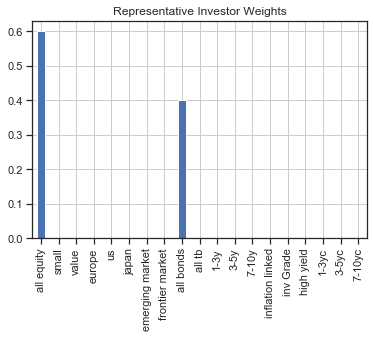

In [3]:
###############################################################################
# market caps page
###############################################################################

market_weights = pd.Series(np.zeros(returns.shape[1]), index = returns.columns)

market_weights["all equity", "all bonds"] = 0.6,0.4

market_weights.plot(kind='bar', title='Representative Investor Weights', 
                                grid='True')
plt.plot()

#fig_latex("mktw", aux, "Representative Investor Weights")

weights = market_weights

To better visualize the values, a plot with annualized expected results and annualized standard deviation is shown in the next picture

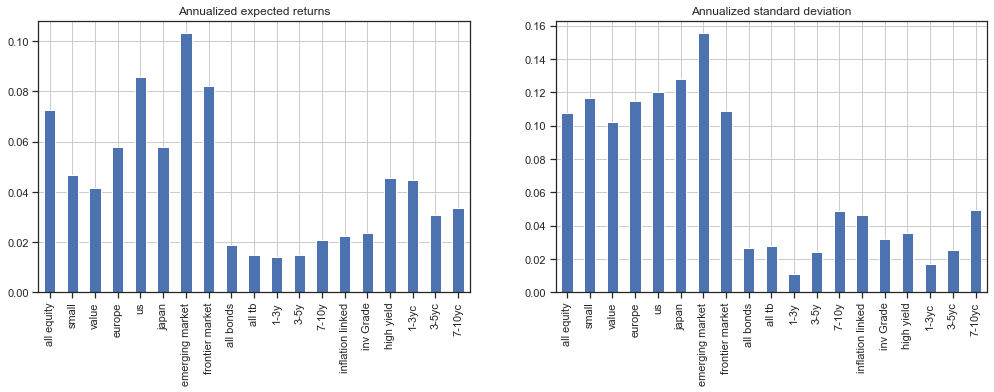

In [4]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1, 2) 
fig = plt.figure(figsize=(17,5))

#Using the 1st row and 1st column for expected results
ax=plt.subplot(gs[0,0])
ax=pd.Series(hh['A. mean']).plot(kind='bar', title="Annualized expected returns",  grid='True')

#Using the 1st row and 2nd column to show volatility
ax1=plt.subplot(gs[0,1])
#ax1.grid(False)
ax1=pd.Series(annualized_vols).plot(kind='bar', title="Annualized standard deviation",  grid='True')

plt.show()

In most of the cases, the equities have higher expected results than the bonds. The exception are for small and value which have performance equal or lower than the high yield bond and 1-3 years corporate bonds. Few more details the corporate bonds have higher expected returns than tresuary bonds.

The standard deviations are higher for equities in general and bonds have lower standard deviations. Looking the two highest bonds expected returns and compare with their volatility we can say they have low volatility for their return, because if we compare those with the the equity small and value we see their expected results are close, but their volatility is huge compared to those bonds. Although the tresuary bonds have the lowest expected only the one 1-3 years have the lowest volatility. The short term bonds period bonds have lower volatility than the medium and high term bonds.

The anualized sharpe ratio is ploted below

$$ Sharp Ratio = \frac{1}{\sqrt{52}} \frac{\mu_{weekly}}{\sigma_{weekly}} $$ 

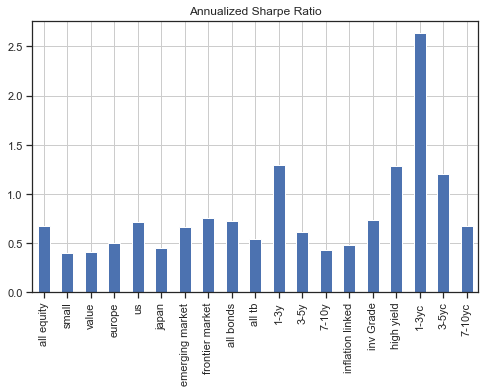

In [5]:
fig = plt.figure(figsize=(8,5))
pd.Series(hh['A. mean']/annualized_vols).plot(kind='bar', title="Annualized Sharpe Ratio",  grid='True')
plt.show()

The annualized sharp ratio shows there is a big return adjusted to risk for short term treasury bonds, high yield, short term and medium term corporate bonds. The correlation plot for the last two years is shown in the heat plot.

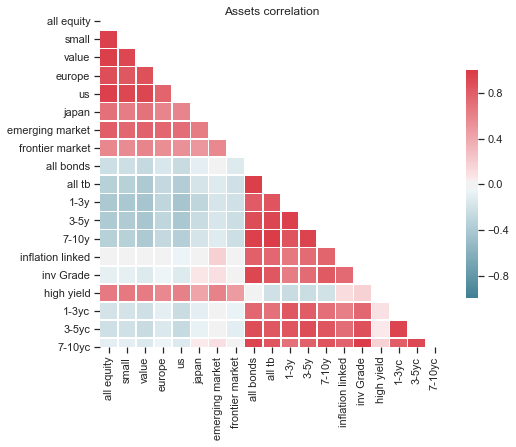

In [6]:
# =============================================================================
# New Cov
# =============================================================================

# =============================================================================
# Garch
# =============================================================================

#vol = pd.DataFrame()
#for i in returns_full:
#     am = arch_model(returns_full[i]*100)
#     result = am.fit()
#     vol[i] = result.conditional_volatility
#
#variance_nw = 52 * (vol/100)**2
#std_nw = (variance_nw**0.5).iloc[-1]

# =============================================================================
# Shrikage
# =============================================================================

#
#np.random.seed(0)
#X = np.random.multivariate_normal(mean=np.diag(returns_full.cov()),
#                                   cov=returns_full.cov(),
#                                   size=50)
#cov = LedoitWolf().fit(returns_full)
#pd.DataFrame(cov.covariance_)*52




# =============================================================================
# 
# =============================================================================


#d_file("vol", round(hh,4), "Data description")

rho_hat = returns_full['2014-09-29':].corr()

#sns.pairplot(returns_full['2014-09-29':])
#sns.plt.show()
#
#sns.pairplot(returns_full['2014-09-29':], kind="scatter")
#plot.show()

#a = sns.pairplot(returns_full['2014-09-29':], kind="reg")
#plt.show()

#g = sns.PairGrid(returns_full)
#g = g.map_diag(plt.hist, edgecolor="w")
#g = g.map_offdiag(plt.scatter, edgecolor="w", s=40)


# Generate a mask for the upper triangle
mask = np.zeros_like(rho_hat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
plt.title("Assets correlation")
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(rho_hat, mask=mask)
sns.heatmap(rho_hat, mask=mask, cmap=cmap, vmax=1, vmin=-1,center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .7})
plt.show()

The correaltion between equities are mostly above 0.4. The equities have negative correlation with bonds, except for the high yield bonds which have correlations with equities around below 0.4 and around 0 correlation with the other bonds. Bonds, excluding high yield, have correlation strong positive correaltion between themselfs. 

The correlation analysis shows that between the asset there is a possibility to make a better diversification than the one done know by the client. The client portfolio now has only all equity and all bonds which have negative correlation, but not optimal return adjusted per risk. 

The covariance was calculated with the following formula:

\begin{equation} 
    \Sigma = \hat\sigma_{annualized} \hat\sigma_{annualized}^T  \odot \hat\rho 
\end{equation}

In [7]:
#d_file("corr", round(rho_hat,2), "Correlation Matrix")

# create covariance matrix (L21:R26)
cov_hat = pd.DataFrame(np.multiply(np.matrix(annualized_vols).T@\
                                   np.matrix(annualized_vols),rho_hat),
    columns = rho_hat.columns, index = rho_hat.index)

cov_hat


,all equity,small,value,europe,us,japan,emerging market,frontier market,all bonds,all tb,1-3y,3-5y,7-10y,inflation linked,inv Grade,high yield,1-3yc,3-5yc,7-10yc
all equity,0.011533,0.011952,0.010689,0.010917,0.012495,0.009604,0.013351,0.006784,-0.000620,-0.001021,-0.000471,-0.000998,-0.001775,-0.000011,-0.000290,0.002475,-0.000348,-0.000594,-0.000471
small,0.011952,0.013588,0.011042,0.011248,0.013018,0.009540,0.013645,0.007080,-0.000680,-0.001111,-0.000513,-0.001072,-0.001916,0.000046,-0.000317,0.002716,-0.000375,-0.000614,-0.000500
value,0.010689,0.011042,0.010403,0.010318,0.011438,0.008977,0.012288,0.006603,-0.000731,-0.001119,-0.000478,-0.001048,-0.001949,-0.000171,-0.000418,0.002325,-0.000368,-0.000665,-0.000679
europe,0.010917,0.011248,0.010318,0.013147,0.010496,0.008810,0.013471,0.006805,-0.000476,-0.000882,-0.000364,-0.000812,-0.001549,0.000199,-0.000172,0.002353,-0.000181,-0.000414,-0.000279
us,0.012495,0.013018,0.011438,0.010496,0.014451,0.009217,0.013415,0.006866,-0.000806,-0.001212,-0.000565,-0.001188,-0.002103,-0.000264,-0.000505,0.002621,-0.000498,-0.000798,-0.000797
japan,0.009604,0.009540,0.008977,0.008810,0.009217,0.016360,0.012684,0.006919,-0.000290,-0.000652,-0.000408,-0.000770,-0.001152,0.000147,0.000269,0.001941,-0.000200,-0.000238,0.000282
emerging market,0.013351,0.013645,0.012288,0.013471,0.013415,0.012684,0.024119,0.009751,-0.000010,-0.000543,-0.000294,-0.000627,-0.000945,0.001355,0.000511,0.003338,-0.000017,-0.000087,0.000815
frontier market,0.006784,0.007080,0.006603,0.006805,0.006866,0.006919,0.009751,0.011808,-0.000367,-0.000634,-0.000244,-0.000597,-0.001173,-0.000047,-0.000093,0.001833,-0.000129,-0.000301,-0.000196
all bonds,-0.000620,-0.000680,-0.000731,-0.000476,-0.000806,-0.000290,-0.000010,-0.000367,0.000693,0.000708,0.000231,0.000568,0.001238,0.000974,0.000783,-0.000020,0.000339,0.000594,0.001225
all tb,-0.001021,-0.001111,-0.001119,-0.000882,-0.001212,-0.000652,-0.000543,-0.000634,0.000708,0.000769,0.000257,0.000625,0.001342,0.000979,0.000745,-0.000204,0.000329,0.000590,0.001172


# Gammas and Excess returns 

The market neutral expected returns were calculate based in the adjustment in all equity
returns. The expected excess returns for this asset were adjusted for 4.5%.

The formula for neutral expected returns is:

$$ E\left[ IER \right] = \gamma\Sigma w_{m} $$

The variables in matrix multiplication are defined as:
1. $\gamma$: Representative Investor's Risk aversion;
2. wm: Market returns.
The adjusment in the formula will come in $\gamma$. We can calculate that in following way:

$$ \gamma = \frac{0.045}{\Sigma_{\left(r, c\right)} w_{m}} $$

Where
1. $\Sigma_(r;c)$: covariance matrix at row r and column c1

In [8]:
###############################################################################
# Main inputs page
###############################################################################
rf = 0.01
global_risk_aversion = (0.045/(cov_hat["all equity"].T@weights))

display(Markdown(f"$\gamma$ = {round(global_risk_aversion,2)}"))

$\gamma$ = 6.75

The excess returns are expressed in the next table

In [9]:
client_risk_aversion = global_risk_aversion

implied_ER = pd.Series(global_risk_aversion *\
                       cov_hat.values @ weights.values,
                       index=weights.index)


inv_cov = la.inv(cov_hat)

# average annual excess returns
avg_returns = returns.mean()*52 - rf

exp = pd.DataFrame([implied_ER.values, avg_returns.values], 
             index = ["Implied Excess Returns(%)", "Avarege Excess Returns(%)"], 
             columns = implied_ER.index).T
                   
#d_file("ret",round(exp*100,4) ,"Expected Excess Returns in Percentage")

round(exp*100,4)                  

,Implied Excess Returns(%),Avarege Excess Returns(%)
all equity,4.5000,6.2608
small,4.6536,3.6850
value,4.1286,3.1370
europe,4.2898,4.7694
us,4.8394,7.5817
japan,3.8084,4.7838
emerging market,5.4006,9.3087
frontier market,2.6465,7.2241
all bonds,-0.0642,0.8991
all tb,-0.2221,0.4919


With a gamma of 6.745 the returns with high risk, or in our case more volatility demands more risk premium, and returns with less volatility demand less risk premium. The values look as expected in relationship to gamma. Two assets deserve more clarification, the "small" and "value". Their avarage excess returns are smaller than the implied excess returns because they
have high covariance with risk assets, and their returns are not high and their volatility are not low.

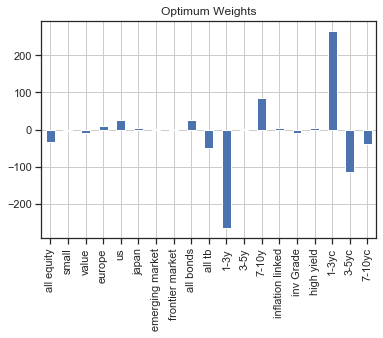

In [10]:
implied_ER_opt = pd.Series(1 / global_risk_aversion *\
                           inv_cov @ implied_ER.values)


avg_ER_opt = pd.Series(1 / global_risk_aversion *\
                       inv_cov @ avg_returns.values)

avg_ER_opt.index= avg_returns.index

aux = avg_ER_opt.plot(kind='bar', title='Optimum Weights', 
                                grid='True')                

#fig_latex("avg_w", aux, "Avarege optimum weights")



# Views
The views are implemeted using Idzorek's method, the views are:

1. Equities (MSCI World) are going to outperform bonds (Treasury+ CB portfolio) with 4%;
2. Small caps are going to outperform MSCI World with 0:5%;
3. Value stocks will have same return as MSCI world;
4. A portfolio of 70% EM and 30% FM will outperform a portfolio of 45% US equity, 35% European equities, and 20% Japanese Equities with 1%;
5. Nominal bonds will underperform Inflation-Linked bonds with 25bps
6. Long-term (7-10Y) Corporate bonds will outperform long-term treasury bonds with 75bps
7. High Yield bonds will outperform Investment Grade Bonds with 50bps 

The matrix of views are shown in the next table


In [11]:
###############################################################################
# views page
###############################################################################
tau = 0.05

views = pd.DataFrame(np.zeros((7,len(weights.index))),columns=weights.index,
                     index=np.array([1,2,3,4,5,6,7]))

# Equities (MSCI World) are going to outperform bonds (Treasury+ CB portfolio) with 4% (90%
# confidence)
views.loc[1,["all equity","all bonds"]] =  np.array([1,-1])

# Small caps are going to outperform MSCI World with 0.5% (30% confidence)
views.iloc[1,0:2] = np.array([-1, 1])

# Value stocks will have same return as MSCI world (30% confidence)
views.loc[3,"value"] = np.array([1])
views.loc[3,"all equity"] = np.array([-1])

# A portfolio of 70% EM and 30% FM will outperform a portfolio of 45% US equity, 35% European
# equities, and 20% Japanese Equities with 1% (75% confidence)
views.loc[4,["emerging market","frontier market"]] = np.array([0.7,0.3])
views.loc[4,"europe":"japan"] = np.array([-0.35,-0.45,-0.2])

# Nominal bonds will underperform Inflation-Linked bonds with 25bps (40% confidence)
views.loc[5,"1-3y":] = -1*np.ones(len(views.loc[5,"1-3y":]))/(len(views.loc[5,"1-3y":]) -1)
views.loc[5,"inflation linked"] = 1

# Long-term (7-10Y) Corporate bonds will outperform long-term treasury bonds with 75bps (60%
# confidence)
views.loc[6,["7-10y", "7-10yc"]] = [-1,1]

# High Yield bonds will outperform Investment Grade Bonds with 50bps (50% confidence)
views.loc[7,["inv Grade", "high yield"]] = [-1,1]

views.T
#d_file("view",views.T,"Views")

,1,2,3,4,5,6,7
all equity,1.0,-1.0,-1.0,0.00,0.000,0.0,0.0
small,0.0,1.0,0.0,0.00,0.000,0.0,0.0
value,0.0,0.0,1.0,0.00,0.000,0.0,0.0
europe,0.0,0.0,0.0,-0.35,0.000,0.0,0.0
us,0.0,0.0,0.0,-0.45,0.000,0.0,0.0
japan,0.0,0.0,0.0,-0.20,0.000,0.0,0.0
emerging market,0.0,0.0,0.0,0.70,0.000,0.0,0.0
frontier market,0.0,0.0,0.0,0.30,0.000,0.0,0.0
all bonds,-1.0,0.0,0.0,0.00,0.000,0.0,0.0
all tb,0.0,0.0,0.0,0.00,0.000,0.0,0.0


The views are relative which makes it more complex to evaluate whether the view is bearish or bullish. this is because we don't know which expected return will move after usisng this tool. Then to compare if the view is bullish or bearlish I used the following formula. 

$$ Perform - views \times E\left[IER\right] $$

The result are expressed in the next table.


In [12]:
P = views

ER = pd.Series(np.array([0.04, 0.005, 0, 0.01,0.0025,0.0075, 0.005]),
               index=np.array(range(1,8)))

bullishOrBearish = (ER - views@implied_ER).to_frame("Values")
aux = []
for i in bullishOrBearish["Values"]:
    if i>0:
        aux.append("Bullish")
    else:
        aux.append("Bearish")

bullishOrBearish['Results'] = aux

bullishOrBearish
#d_file("bullbear", bullishOrBearish, "Bullish and Bearish")

,Values,Results
1,-0.005642,Bearish
2,0.003464,Bullish
3,0.003714,Bullish
4,0.008664,Bullish
5,0.000340,Bullish
6,0.002256,Bullish
7,-0.004023,Bearish


How the views will perform and the confidence are expressed in the next table.

In [13]:


Q = ER

conf_views = pd.Series(np.array([0.9, 0.3, 0.3, 0.75, 0.4, 0.6, 0.5]),
                 index=np.array(range(1,8)))

aux = pd.DataFrame([ER.values, conf_views.values], columns = views.index+1,
             index = ["Outperform", "Confidence"])

aux
#d_file("exp_out", aux, "Expected outperformance and confidence based on views")

,2,3,4,5,6,7,8
Outperform,0.04,0.005,0.0,0.01,0.0025,0.0075,0.005
Confidence,0.90,0.300,0.3,0.75,0.4000,0.6000,0.500


# Omega

Next step I compute the omega ($\Omega$). To do that we need to compute the $\alpha$ using the
confidence in our views. The formula for $\alpha$ is

\begin{equation} 
    \alpha =  \frac{1}{1 - confidence}
\end{equation}

To calculate the omega

\begin{equation}
    \Omega = I \times diag\left( \left( \alpha \times I \right) P^T \times \tau\Sigma \times P \right) 
    \label{t1}\tag{1}
\end{equation}

Where

1. I is a identity matrix;
2. P is the views matrix;
3. diag(.) is the diagonal of the matrix;
4. $\tau$ is a scalar.

The choice of $\tau$ could be based in the paper by Blamont and Firoozye (2003), where they
interpret the $\tau\Sigma$ as the standard error of the estimate of the Implied Equilibrium Return thus,
the $\tau$ is approximately 1 divided by the number of observations. Following this approuach tau
would be

$$ \tau = \frac{1}{104} \approx 0.01 $$

The diagonal of omega is reported in the table below.

In [14]:

alpha = (1 - conf_views)/conf_views

omega_diag = np.diag(np.diag(alpha)@P@(tau*cov_hat)@P.T)
omega = pd.DataFrame(np.eye(7)*omega_diag, index = P.index, columns = P.index) 

pd.DataFrame(omega_diag, columns= ["Values"], index = views.index)

#d_file("omega", pd.DataFrame(omega_diag, columns= ["Values"], index = views.index), "Diagonal of Omega", longtable=True)


,Values
1,0.000075
2,0.000142
3,0.000065
4,0.000094
5,0.000071
6,0.000022
7,0.000094


# Black-Litterman expected excess returns

To calculate the expected excess returns for Black and Litterman model

$$ E\left[ Returns_{BL} \right] = \mu_{BL} = v_{1} E\left[IER \right] + v_{2} Q $$

Where
1. Q is the values of the performance values;
2. $v1$ and $v2$ will be expressed in the following steps.

To calculate $v1$ and $v2$, first estimate the variance of the new returns. The formula for that is

\begin{equation}
    \hat\sigma = \left(\tau\Sigma\right) ^{-1} + P^{T} \Omega ^{-1} P  
    \label{t11}\tag{2}
\end{equation}

Then the $v1$ and $v2$ are:

\begin{equation}
    v_{1} = \hat\sigma^{-1} \left(\tau\Sigma\right)^{-1}
    \label{t3}\tag{3}
\end{equation}

\begin{equation}
    v_{2} = \hat\sigma^{-1} P^{T} \Omega^{-1}
    \label{t4}\tag{4}
\end{equation}

The found values are shown in the next table together with market neutral excess returns.

In [15]:



inv_omega = la.inv(omega)


P_aux = P
P_aux.index = (P.T @ inv_omega).columns

sigma_bar = inv_cov / tau + P.T @ inv_omega @ P_aux
inv_sigma_bar = la.inv(sigma_bar)
v1 = inv_sigma_bar @ inv_cov / tau
v2 = inv_sigma_bar @ P.T @ inv_omega

# Black-Litterman expected returns (D29:D35)
bl = v1 @ implied_ER.values + v2 @ Q.values
bl.index = weights.index
aux = pd.DataFrame([bl.values,implied_ER], index=["BL", "Market neutral"], columns = weights.index).T *100

aux
#d_file("bl_exr",round(pd.DataFrame([bl,implied_ER], index=["BL", "Market neutral"], columns = weights.index).T *100,4), "Excess returns", longtable = True)


,BL,Market neutral
all equity,4.105793,4.500000
small,4.340259,4.653615
value,3.849837,4.128648
europe,4.010109,4.289759
us,4.284597,4.839355
japan,3.667967,3.808386
emerging market,5.716708,5.400611
frontier market,2.873784,2.646515
all bonds,0.073265,-0.064181
all tb,-0.103924,-0.222128


The found values show that the views are taken into account in the black-Litterman model. The returns changes are explained by the choice how confident you are about your returns. One important point is that the views with big confidence are more representative than the views with lower confidence. The next table shows a comparison about between views and results.

In [16]:
aux = pd.DataFrame(views.values@bl.values, columns = ["BL"],index = ER.index)

aux["Implied"] = ER

aux["Confidence"] = conf_views

round(aux*100,4)

#d_file("view_p", round(aux*100,4), "Views Performance in percentage")


,BL,Implied,Confidence
1,4.0325,4.00,90.0
2,0.2345,0.50,30.0
3,-0.2560,0.00,30.0
4,0.7986,1.00,75.0
5,0.2674,0.25,40.0
6,0.6403,0.75,60.0
7,0.7200,0.50,50.0


We can derive the returns distribution follow some assumptions as the normal distribution of the previus returns and the views. The new distribution will be, a normal with these parameters

$$ R_{BL} \sim Normal\left( \mu_{BL}, \sigma^{-1} \right) $$

# Optimum Weights With no Constraint

Assuming the utility function can be expressed as

\begin{equation}
    U(\mu, \Sigma, \gamma, w) = \mu^{T}w - \frac{\gamma}{2} w^T \Sigma w 
\end{equation}

The optimum weights with no constrait was calculated with the following formula

$$ w = \frac{\Sigma^{-1} \mu}{\gamma} $$

The formula applied for BL retuns results in values shown in the following graph and table.

                   Weights
all equity         13.7397
small              13.8740
value              29.1632
europe             -5.5483
us                 -7.1335
japan              -3.1704
emerging market    11.0965
frontier market     4.7557
all bonds          43.2231
all tb             -0.0000
1-3y                0.2279
3-5y                0.2279
7-10y             -36.2322
inflation linked   -1.8229
inv Grade          17.5036
high yield        -17.0478
1-3yc               0.2279
3-5yc               0.2279
7-10yc             36.6879
Sum               100.0000


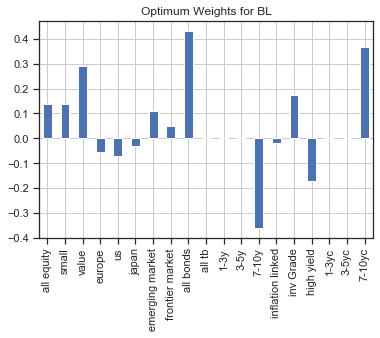

In [17]:
# Black-Litterman optimal weights (D29:D35) 
bl_opt = inv_cov @ bl / client_risk_aversion

test_a = sigma_bar @ bl / client_risk_aversion


df_aux = pd.Series(bl_opt, index = weights.index)
df_aux["Sum"] = sum(df_aux)

print(round(df_aux.to_frame("Weights")*100,4))
#d_file("wbl", round(df_aux.to_frame("Weights")*100,4), "Optimum Weights with no constraint in percentage", longtable =True)
aux = pd.Series(bl_opt, index = weights.index).plot(kind='bar', title='Optimum Weights for BL',grid='True')

The sharpe Ratio was calculated with returns covariance matrix $\left(\Sigma\right)$ and BL covariance
matrix $\left(\hat\sigma^{-1}\right)$

In [18]:
pd.DataFrame([round((bl@bl_opt)/((bl_opt@cov_hat@bl_opt)**0.5),4),
                     round(bl@bl_opt.T/((bl_opt@la.inv(sigma_bar)@bl_opt)**0.5),4)],
              columns = ["Shape Ratio"], index = ["Returns std", "BL std"])


#d_file("shp_rn",
#       pd.DataFrame([round((bl@bl_opt)/((bl_opt@cov_hat@bl_opt)**0.5),4),
#                     round(bl@bl_opt.T/((bl_opt@la.inv(sigma_bar)@bl_opt)**0.5),4)],
#              columns = ["Shape Ratio"], index = ["Returns std", "BL std"]),
#                     "Sharpe Ratio")

#bl@test_a/((test_a@la.inv(sigma_bar)@test_a)**0.5)




,Shape Ratio
Returns std,0.4149
BL std,3.8188


The long treasury bonds (7-10y) are financing the long corporate bond (7-10yc) and high yield bond are financing the inv Grade. Beyond the long treasury bonds and high yield, the optimum weights have short positions in Europe, US, Japan and inflation linked. The 1-3 and 3-5 of treasury and corporate bonds are the same. All bonds has the biggest weights. The position in all tb (all treasuary bonds) is equal to 0. Last comment the sum of weigths is equal to 1, which means no investment to in risk free rate.

# Optimum Weights With Constraint

Now to calculate the optimum weights assuming the same utility function as the expressed in the formula above, two coinstrainst will be set, which are

1. The sum of weights is equal to 1;
2. No short positions, in other words.

$$ w_{i} \geq 0, \ i = 1,2,...,19 $$

With this two constraints, the weights are less or equal to one

One way to calculate the weights of this portfolio is using Karush-Kuhn-Turcker (KKT)
conditions:

$$ max_{w} U(\mu, \Sigma, \gamma, w) - \lambda_1 \left(\sum_{i=1}^{19} w_{i} - 1 \right) + \sum_{j=1}^{19} u_{j} w_j $$ 

Where:

1. $U(\mu, \Sigma, \gamma, w)$ is the utility function with mean and covariance matrix constant;
2. $\lambda_1$ and $u_j$ are the KKT multipliers.

the results were calculated using the function minimize from scipy.optimize in python. The result are reporting in the next graph 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.012684068581467856
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28
                  Weights
all equity         1.2633
small             12.5410
value             27.5078
europe             0.0000
us                 0.5812
japan             -0.0000
emerging market   10.0994
frontier market    4.9316
all bonds          3.0612
all tb             0.0390
1-3y               0.0000
3-5y               0.0000
7-10y              0.0000
inflation linked   0.0000
inv Grade         19.8858
high yield        -0.0000
1-3yc              5.1362
3-5yc              3.7591
7-10yc            18.5374


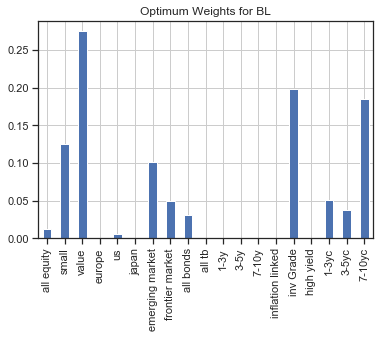

In [19]:
###############################################################################
# Constrained optimization
###############################################################################

mu = bl[:, None]

def mv(w, gamma, mu, vcv):
    """ Objective function """
    return -(np.dot(w.T, mu) - 0.5 * gamma * w.T @ vcv @ w)[0]

def dmv(w, gamma, mu, vcv):
    """ Objective function """
    return -(mu.T[0] - gamma * w @ vcv)


cons = ({'type': 'ineq',
         'fun' : lambda x: np.sum(x)-1,
         'jac' : lambda x: np.ones(len(x))},
         {'type': 'ineq',
         'fun' : lambda x: np.array([x[i] for i in range(len(x))]),
         'jac' : lambda x: np.eye(len(x))})

res = minimize(mv, np.ones(len(bl))/len(bl),
               args=(client_risk_aversion ,mu, cov_hat),
               jac=dmv, constraints=cons, method='SLSQP',
               options={'disp': True})


#res1 = minimize(mv, ww,
#               args=(client_risk_aversion, mu, cov_hat),
#               jac=dmv, constraints=cons, method='SLSQP',
#               options={'disp': True})

y = res.x

print(round(pd.Series(y, index = weights.index)*100,4).to_frame("Weights"))
pd.Series(y, index = weights.index).plot(kind='bar', title='Optimum Weights for BL',grid='True')
plt.show()
#fig_latex("c_weig",a, "BL Optimum Weights with Constraint")
#

The sharpe Ratio was calculated with returns covariance matrix $\left(\Sigma\right)$ and BL covariance
matrix $\left(\hat\sigma^{-1}\right)$

In [71]:

sp = pd.DataFrame([round((bl@y)/((y@cov_hat@y)**0.5),4),
             round(bl@y/((y@la.inv(sigma_bar)@y)**0.5),4)],
      columns = ["Shape Ratio"], index = ["Returns std", "BL std"])
sp
#d_file("shp_rc",
#       pd.DataFrame([round((bl@y)/((y@cov_hat@y)**0.5),4),
#                     round(bl@y/((y@la.inv(sigma_bar)@y)**0.5),4)],
#              columns = ["Shape Ratio"], index = ["Returns std", "BL std"]),
#                     "Sharpe Ratio")

,Shape Ratio
Returns std,0.3446
BL std,3.0972


# Robustness for tau $\left(\tau \right)$

Using the formulas for $\alpha$ and $\Omega$, but now tau is divided by a constant c $\left(\frac{\tau}{c}\right)$
	
Let $c$ be a changing in tau and c is different from $0$. Then
		
\begin{equation}
		I \times diag\left(\left(\alpha \times I \right)\times P^{T} \times \frac{\tau}{c} \Sigma \times P \right) = \frac{1}{c} \ \underbrace{I \times diag\left(\left(\alpha \times I \right)\times P^{T} \times \tau \Sigma \times P \right)}_{\Omega} = \frac{\Omega}{c}.
        \label{nt0}\tag{6}
\end{equation}


Using the previous result,
	
\begin{equation}
		\left(\frac{\tau}{c}\Sigma\right)^{-1} + P^{T} \left( \frac{\Omega}{c} \right)^{-1} P = c \left(\tau\Sigma\right)^{-1} + c P^{T} \left( \Omega \right)^{-1} P = c \underbrace{\left(\left(\tau\Sigma\right)^{-1} + P^{T} \left( \Omega \right)^{-1} P\right)}_{\hat\sigma}
\end{equation}
	
\begin{equation}
		\left(\frac{\tau}{c}\Sigma\right)^{-1} + P^{T} \left( \frac{\Omega}{c} \right)^{-1} P = \hat\sigma c
        \label{nt1}\tag{7}
\end{equation}
	
Replace the results in $\eqref{nt0}$ and $\eqref{nt1}$ in formulas #mjx-eqn-t3 and $\ref{eq:t4}$. The result is
	
\begin{equation}
		 \left(\hat\sigma c\right)^{-1} \left(\frac{\tau}{c}\Sigma\right)^{-1} = \frac{1}{c}\left(\hat\sigma\right)^{-1} c \left(\tau\Sigma\right)^{-1} = v_{1} 
\end{equation}
	
\begin{equation}
		\left(\hat\sigma c\right)^{-1} P^{T} \left(\frac{\Omega}{c}\right)^{-1} = \frac{\hat\sigma^{-1} }{c} P^{T} \Omega^{-1} c = v_{2}
\end{equation}	


For this the result of Black-Litterman model will be the same when the tau $\left(\tau\right)$ change.
	
Since the returns do not change, the values of weights will be the same. However, what tau changes in Black-Litterman model is the variance of the distribution. Assuming the the returns and values follow a normal the new distribution will be
	
\begin{equation}
	R_{BL} \sim Normal\left(\mu_{BL}, \left[c \hat\sigma \right]^{-1}\right)
\end{equation}

# Changing in Client Gamma
	
A changing in gamma will not affect the implied volatility, but it will affect directly the weights. I high Gamma implied that the client is more risk aversion, a gamma equal to zero says that the client is a neutral risk and a negative gamma means that the client is risk seeker. 
	
In previous part of this work I have been working with representative investor's gamma about $6.745$. From this part, I will work with two client gammas which are $2$ and $10$, and compare the results that I will obtain.
	
The client gamma will affect his ultility function, assuming that the utility function is the same as expressed in the formula \ref{utl}. Now the formula is
	
\begin{equation}
	U(\mu, \Sigma, \gamma_{c}, w) = \mu^{T} w - \frac{\gamma_{c}}{2}w^{T}\Sigma w
\end{equation}
	
and the new optimum weight with no constraints will be
	
\begin{equation}
	w_{opt} = \frac{\Sigma^{-1} \mu}{\gamma_{c}}
\end{equation}
	
The results are expressed in the next graphs and tables

<Figure size 576x360 with 0 Axes>

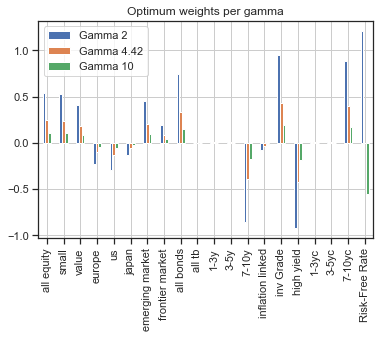

In [138]:
weights_gammas = pd.DataFrame([inv_cov @ bl / gamma for gamma in np.array([2,client_risk_aversion,10])], columns=weights.index, index=["Gamma " + str(round(gamma,2)) for gamma in [2, client_risk_aversion,10] ])
weights_gammas['Risk-Free Rate'] = weights_gammas.sum(axis=1) - 1

fig = plt.figure(figsize=(8,5))
weights_gammas.T.plot(kind="bar", grid=True, title="Optimum weights per gamma") 
plt.show()



So, I want to point out, in Black-Litterman model, for when the client gamma $\left(\gamma_{c}\right)$ is different from the representative investor $\left( \gamma \right)$ the sum of weights is different from one. That means I included the risk free rate or to financing or as a investment in the portfolio.
	
The weights movement remains the same direction, but the intensity changed. 

One way to better understand the how gamma changed the portfolio weights is calculating the first derivade of the optimum weights.
	
\begin{equation}
	\frac{\partial w_{opt}}{\partial \gamma_{c}} = -\frac{\Sigma^{-1} \mu}{\gamma^{2}_{c}}
\end{equation}

This means that gamma has a negative relationship with weigths. 
	
Back to the graphs, the risk assets (exclude the risk-free) they look the same, however the y axis has a big change. While gamma 10 has more than $60\%$ invested in the risk assets, gamma 2 has more than $300\%$ invested in the risk assets. For gamma 10, it has more than $30\%$ invested in the risk free whereas gamma 2 borrow or short the risk free rate in about $230\%$. 
	
That leads to a statement for Black-Litterman model. When the client's gamma is bigger than representative investor's gamma, the client optimum weights with no constraints will invest in the risk free rate. When the risk opposite occurs, or the client's gamma is smaller than the representative investor, the optimum weights with no constraints for that client will be short in the risk free. Lastly when the gammas are equals the risk free weight will be zero, or all weights will be allocated in the risk assets.

# Alternative Ways of Measuring the Covariance Matrix

In this subsection I will apresent some different ways to creat to estimate the covariance matrix.


## Shrinkage

Ledoit and Wolf (2003) (“A Well-Conditioned Estimator for Large-Dimensional Covariance Matrices”, Ledoit and Wolf, Journal of Multivariate Analysis, Volume 88, Issue 2, February 2004, pages 365-411.) argument that some applied problems, as mean-variance efficient portfolio, require a estimate of a covariance matrix. However the usual estimator (Sample Covariance Matrix) is known to perform poorly. For that, they created a new way to estimate a covariance matrix which smooths the extreme values of the covariance matrix. The objective of shrinkage is to pull these extreme values toward a central value. 

The central value is expressed in the nexts formulas

\begin{equation}
    F =
    \begin{bmatrix}
    f_{1,1}&\cdots & f_{1,N} \\
    \vdots & \ddots & \vdots\\
    f_{N,1}&\cdots &f_{NN}
    \end{bmatrix} 
\end{equation}

\begin{equation}
    f_{i,i} = \sigma_{i,i}
\end{equation}

\begin{equation}
    f_{i,j} = \bar \rho \sqrt{\sigma_{i,i}\sigma_{f,f}}
\end{equation}

\begin{equation}
    \bar\rho = \frac{2}{\left(N-1\right)N} \ \vec{I}^{T}  \rho \ \vec{I}
\end{equation}


Where:
1. $\sigma_{i,i}$: standard deviation;
2. $\rho$: correlation matrix;
3. $\vec{I}$: column vector of 1;
4. $F$: the central values or central matrix.

The new covariance based in the Shrinkage method 

\begin{equation}
    \Sigma_{Sk} = \delta F + \left(1- \delta \right) \hat\Sigma
\end{equation}

$\delta$ is defined as

\begin{equation}
    \delta = \frac{k}{T}
\end{equation}

\begin{equation}
    k = \frac{\pi - \ell}{\gamma}
\end{equation}

\begin{equation}
    \pi =  \vec{I}^{T} AsyVar\left(\sqrt{T} \sigma \right) \vec{I}
\end{equation}

\begin{equation}
    \ell = \vec{I}^{T} AsyCov\left(\sqrt{T} \sigma, \sqrt{T} F \right) \vec{I}
\end{equation}
	
\begin{equation}
	\gamma = \sum_{i=1}^N \sum_{j=1}^{N}\left( \sigma_{i,j} - f_{i,j} \right)^{2}
\end{equation}
	
The calculation was made in python using the library sklearn.covariance and the function LedoitWolf. The estimation was based on the returns from 29/09/2014.

In [46]:
rho_hat = returns_full['2014-09-29':].corr()

cov = LedoitWolf().fit(returns_full['2014-09-29':])

cov_hat = pd.DataFrame(cov.covariance_*52, columns = rho_hat.columns, index = rho_hat.index)

round(cov_hat,4) # "Shrinkage Covariance Matrix

,all equity,small,value,europe,us,japan,emerging market,frontier market,all bonds,all tb,1-3y,3-5y,7-10y,inflation linked,inv Grade,high yield,1-3yc,3-5yc,7-10yc
all equity,0.017517,0.018817,0.016857,0.022716,0.018125,0.012538,0.025178,0.007699,-0.000212,-0.000434,-0.000110,-0.000437,-0.001295,-0.000008,-0.000125,0.002697,-0.000115,-0.000263,-0.000311
small,0.016449,0.020037,0.016061,0.021588,0.017417,0.011487,0.023734,0.007411,-0.000215,-0.000435,-0.000111,-0.000433,-0.001289,0.000031,-0.000126,0.002730,-0.000114,-0.000251,-0.000305
value,0.016794,0.018303,0.017582,0.022606,0.017470,0.012340,0.024399,0.007891,-0.000264,-0.000500,-0.000118,-0.000483,-0.001496,-0.000131,-0.000190,0.002668,-0.000127,-0.000311,-0.000473
europe,0.015302,0.016634,0.015285,0.026004,0.014301,0.010804,0.023862,0.007255,-0.000153,-0.000352,-0.000080,-0.000334,-0.001061,0.000136,-0.000070,0.002408,-0.000056,-0.000172,-0.000173
us,0.016668,0.018322,0.016126,0.019524,0.019048,0.010757,0.022616,0.006966,-0.000247,-0.000460,-0.000118,-0.000465,-0.001371,-0.000171,-0.000195,0.002554,-0.000146,-0.000316,-0.000471
japan,0.012036,0.012615,0.011891,0.015397,0.011229,0.018246,0.020090,0.006595,-0.000083,-0.000232,-0.000080,-0.000283,-0.000706,0.000090,0.000098,0.001777,-0.000055,-0.000089,0.000157
emerging market,0.013831,0.014914,0.013454,0.019461,0.013510,0.011496,0.031886,0.007683,-0.000002,-0.000160,-0.000048,-0.000191,-0.000479,0.000683,0.000153,0.002526,-0.000004,-0.000027,0.000374
frontier market,0.009977,0.010987,0.010264,0.013957,0.009816,0.008903,0.018124,0.013517,-0.000124,-0.000265,-0.000056,-0.000258,-0.000843,-0.000034,-0.000040,0.001969,-0.000042,-0.000131,-0.000128
all bonds,-0.003257,-0.003768,-0.004059,-0.003487,-0.004113,-0.001334,-0.000066,-0.001464,0.001142,0.001058,0.000191,0.000875,0.003178,0.002486,0.001189,-0.000077,0.000393,0.000927,0.002849
all tb,-0.005275,-0.006058,-0.006111,-0.006354,-0.006091,-0.002947,-0.003547,-0.002492,0.000839,0.001440,0.000208,0.000948,0.003390,0.002460,0.001114,-0.000770,0.000375,0.000906,0.002682


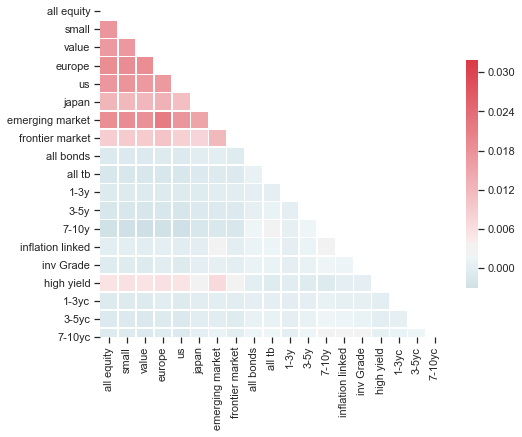

In [56]:
# Generate a mask for the upper triangle
mask = np.zeros_like(cov_hat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#
# Draw the heatmap with the mask and correct aspect ratio

sns.heatmap(cov_hat, mask=mask, cmap=cmap, vmax=np.max(cov_hat.values),
            vmin=np.min(cov_hat.values),center=np.mean(cov_hat.values),
            square=True, linewidths=0.5, cbar_kws={"shrink": .7})
plt.show()

#d_file("corr", round(rho_hat,2), "Correlation Matrix")

In [57]:
global_risk_aversion = (0.045/(cov_hat["all equity"].T@weights))

client_risk_aversion = global_risk_aversion

implied_ER = pd.Series(global_risk_aversion *\
                       cov_hat.values @ weights.values,
                       index=weights.index)


inv_cov_shirnkage = la.inv(cov_hat)

# average annual excess returns
avg_returns = returns.mean()*52 - rf

exp = pd.DataFrame([implied_ER.values], 
             index = ["Implied Excess Returns(%)"], 
             columns = implied_ER.index).T

round(exp*100,4)        

#d_file("skret",round(exp*100,4) ,"Expected Implied Excess Sk-Returns in Percentage", longtable=True)

,Implied Excess Returns(%)
all equity,4.5000
small,4.5083
value,4.2808
europe,4.8170
us,4.4330
japan,3.2000
emerging market,4.9485
frontier market,2.2498
all bonds,-0.0186
all tb,-0.2345


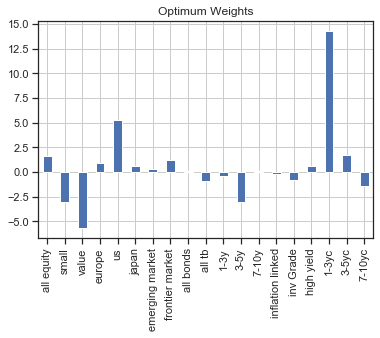

In [64]:
#implied_ER_opt = pd.Series(1 / global_risk_aversion *\
#                           inv_cov @ implied_ER.values)


#avg_ER_opt = pd.Series(1 / global_risk_aversion *\
#                       inv_cov @ avg_returns.values)

avg_ER_opt.index= avg_returns.index

avg_ER_opt.plot(kind='bar', title='Optimum Weights', 
                                grid='True')                
plt.show()

#fig_latex("avg_w", aux, "Avarege optimum weights")

In [62]:
###############################################################################
# views page
###############################################################################


omega_diag_shirnkage = np.diag(np.diag(alpha)@P@(tau*cov_hat)@P.T)
omega_shirnkage = pd.DataFrame(np.eye(7)*omega_diag_shirnkage, index = P.index, columns = P.index) 

#d_file("shkomega", pd.DataFrame(omega_diag, columns= ["Values"], index = views.index), "Diagonal of Sk-Omega", longtable=True)



inv_omega_shirnkage = la.inv(omega_shirnkage)


P_aux = P
P_aux.index = (P.T @ inv_omega_shirnkage).columns

sigma_bar_shirnkage = inv_cov_shirnkage / tau + P.T @ inv_omega_shirnkage @ P_aux
inv_sigma_bar_shirnkage = la.inv(sigma_bar_shirnkage)
v1_shirnkage = inv_sigma_bar_shirnkage @ inv_cov_shirnkage / tau
v2_shirnkage = inv_sigma_bar_shirnkage @ P.T @ inv_omega_shirnkage

# Black-Litterman expected returns (D29:D35)
bl_shirnkage = v1_shirnkage @ implied_ER.values + v2_shirnkage @ Q.values

round(pd.DataFrame([bl.values,bl_shirnkage.values,implied_ER.values],
                   index=["BL","BL Shrinkage","Market neutral"], columns = weights.index).T *100,4)
#d_file("skbl_exr",round(pd.DataFrame([bl,implied_ER], index=["BL", "Market neutral"], columns = weights.index).T *100,4), "Excess returns (SK)", longtable = True)
#
#
#aux = pd.DataFrame(views@bl, columns = ["BL"])
#
#aux.index = ER.index
#
#aux["Implied"] = ER
#
#aux["Confidence"] = conf_views
#
#d_file("view_p", round(aux*100,4), "Views Performance in percentage")



,BL,BL Shrinkage,Market neutral
all equity,4.1029,4.1052,4.5000
small,4.3054,4.2387,4.5083
value,3.9976,3.9564,4.2808
europe,4.4968,4.4631,4.8170
us,3.9344,3.9453,4.4330
japan,3.2053,3.1171,3.2000
emerging market,5.6709,5.5783,4.9485
frontier market,2.5766,2.5386,2.2498
all bonds,0.1465,0.1206,-0.0186
all tb,-0.0458,-0.0816,-0.2345


                  Normal Vol  Shrinkage Vol
all equity             24.57          36.57
small                  23.71          15.01
value                  18.31           9.97
europe                -10.20          -9.29
us                    -13.12         -11.95
japan                  -5.83          -5.31
emerging market        20.41          18.59
frontier market         8.75           7.97
all bonds              33.41          38.46
all tb                  0.00          -0.00
1-3y                    0.46           0.10
3-5y                    0.46           0.10
7-10y                 -38.84         -26.71
inflation linked       -3.67          -0.83
inv Grade              42.79          23.55
high yield            -41.87         -23.35
1-3yc                   0.46           0.10
3-5yc                   0.46           0.10
7-10yc                 39.76          26.92


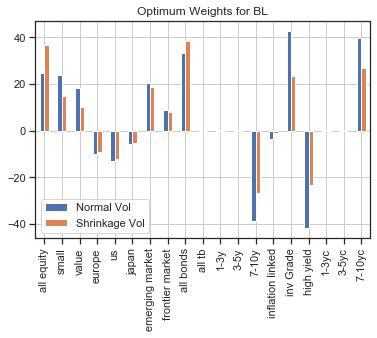

In [101]:
#aux[]

# Black-Litterman optimal weights (D29:D35) 
bl_opt_shirnkage = inv_cov_shirnkage @ bl_shirnkage / client_risk_aversion

#test_a = sigma_bar_shirnkage @ bl_shirnkage / client_risk_aversion

df_aux = pd.Series(bl_opt_shirnkage, index = weights.index)
df_aux["Sum"] = sum(df_aux)

comp_unsc_weights = pd.DataFrame([bl_opt,bl_opt_shirnkage], columns=weights.index, index=["Normal Vol", "Shrinkage Vol"]).T * 100
print(round(comp_unsc_weights,2))

comp_unsc_weights.plot(kind='bar', title='Optimum Weights for BL',grid='True')
plt.show()

#d_file("sk_wbl", round(df_aux.to_frame("Weights")*100,4), "Optimum Weights with no constraint and with SK covariance in percentage", longtable =True)

#fig_latex("SK_ER_weigts", aux, "BL optimum weights with no constraint")

In [73]:
#d_file("sk_shp_rn",
#       pd.DataFrame([round((bl@bl_opt)/((bl_opt@cov_hat@bl_opt)**0.5),4),
#                     round(bl@bl_opt.T/((bl_opt@la.inv(sigma_bar)@bl_opt)**0.5),4)],
#              columns = ["Shape Ratio (SK)"], index = ["Returns std", "BL std"]),
#                     "Sharpe Ratio")

#bl@test_a/((test_a@la.inv(sigma_bar)@test_a)**0.5)

sp_shirnkage = pd.DataFrame([round((bl_shirnkage@bl_opt_shirnkage)/((bl_opt_shirnkage@cov_hat@bl_opt_shirnkage)**0.5),4),
                     round(bl_shirnkage@bl_opt_shirnkage.T/((bl_opt_shirnkage@la.inv(sigma_bar_shirnkage)@bl_opt_shirnkage)**0.5),4)],
              columns = ["Shape Ratio (SK)"], index = ["Returns std", "BL std"])
pd.concat([sp,sp_shirnkage], axis=1)

,Shape Ratio,Shape Ratio (SK)
Returns std,0.3446,0.3447
BL std,3.0972,2.8926


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.013071655347516333
            Iterations: 30
            Function evaluations: 31
            Gradient evaluations: 30
                  Normal Vol  Shrinkage Vol
all equity              1.26          14.32
small                  12.54          12.00
value                  27.51           6.55
europe                  0.00           0.00
us                      0.58           0.98
japan                  -0.00           0.00
emerging market        10.10          16.73
frontier market         4.93           7.04
all bonds               3.06          17.19
all tb                  0.04           1.81
1-3y                    0.00           1.15
3-5y                    0.00          -0.00
7-10y                   0.00           0.00
inflation linked        0.00          -0.00
inv Grade              19.89          15.01
high yield             -0.00          -0.00
1-3yc                   5.14          

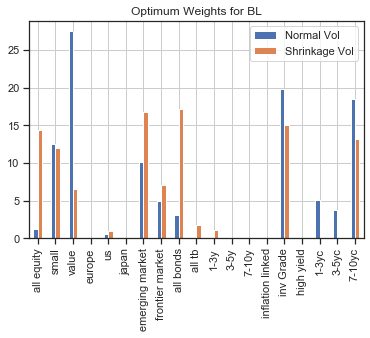

In [102]:

###############################################################################
# Constrained optimization
###############################################################################

mu = bl_shirnkage[:, None]

res_shirnkage = minimize(mv, np.ones(len(bl))/len(bl),
               args=(client_risk_aversion ,mu, cov_hat),
               jac=dmv, constraints=cons, method='SLSQP',
               options={'disp': True})


#res1 = minimize(mv, ww,
#               args=(client_risk_aversion, mu, cov_hat),
#               jac=dmv, constraints=cons, method='SLSQP',
#               options={'disp': True})

y_shirnkage = res_shirnkage.x

comp_weigths = pd.DataFrame([res.x.T,res_shirnkage.x.T], columns = weights.index, index=["Normal Vol", "Shrinkage Vol"]).T * 100
print(round(comp_weigths,2))
comp_weigths.plot(kind="bar", title='Optimum Weights for BL',grid='True')
plt.show()
#fig_latex("skc_weig",a, "BL Optimum Weights with Constraint")

#d_file("skw_blc", round(pd.Series(y, index = weights.index)*100,4).to_frame("Weights SK"), "BL Weights with Constraint", longtable = True)




#d_file("skshp_rc",
#       pd.DataFrame([round((bl@y)/((y@cov_hat@y)**0.5),4),
#                     round(bl@y/((y@la.inv(sigma_bar)@y)**0.5),4)],
#              columns = ["SK Shape Ratio"], index = ["Returns std", "BL std"]),
#                     "Sharpe Ratio")

# Garch model

$$ r_{t}= \mu + \epsilon_{t} $$
 
$$ \sigma^{2}_t = w + \alpha\epsilon^{2}_{t-1} + \beta\sigma^{2}_{t-1} $$

$$ \epsilon_t = \sigma_t\epsilon_t, \ \epsilon \sim N\left(0,1\right) $$


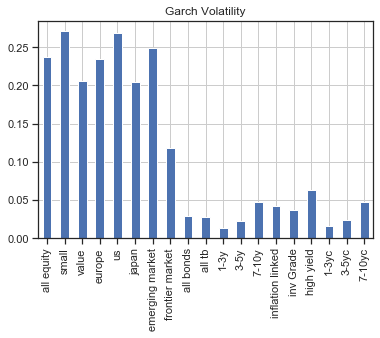

In [157]:
# =============================================================================
# Garch
# =============================================================================

vol = pd.DataFrame()
for i in returns_full:
     am = arch_model(returns_full[i]*1000)
     result = am.fit(update_freq=0, disp=False)
     vol[i] = result.conditional_volatility

variance_nw = 52 * (vol/1000)**2
std_nw = (variance_nw**0.5).iloc[-1]

std_nw.plot(kind="bar", title="Annualized Garch Volatility", grid=True)
plt.show()


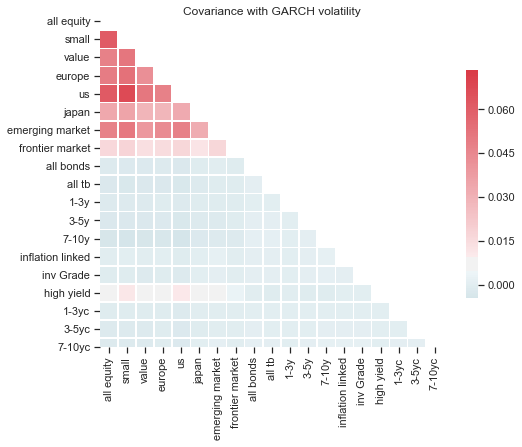

In [160]:
rho_hat = returns_full['2014-09-29':].corr()

cov_hat_garch = pd.DataFrame(np.multiply(np.matrix(std_nw).T@\
                                   np.matrix(std_nw),rho_hat),
    columns = rho_hat.columns, index = rho_hat.index)

#print(round(cov_hat,4))
# Generate a mask for the upper triangle
mask = np.zeros_like(rho_hat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(rho_hat, mask=mask)
sns.heatmap(cov_hat_garch, mask=mask, cmap=cmap, vmax=np.max(cov_hat_garch.values),
            vmin=np.min(cov_hat_garch.values),
            center=np.mean(cov_hat_garch.values),
            square=True, linewidths=0.5, cbar_kws={"shrink": .7})
plt.title("Covariance with GARCH volatility")
plt.show()
#d_file("corr", round(rho_hat,2), "Correlation Matrix")

# create covariance matrix (L21:R26)


#d_file("cov_hat", round(cov_hat,4), "Covariance Matrix in percentage")

In [161]:
global_risk_aversion_garch = (0.045/(cov_hat_garch["all equity"].T@weights))

client_risk_aversion_garch = global_risk_aversion_garch

implied_ER = pd.Series(global_risk_aversion_garch *\
                       cov_hat_garch.values @ weights.values,
                       index=weights.index)


inv_cov = la.inv(cov_hat_garch)

# average annual excess returns
avg_returns = returns.mean()*52 - rf

exp = pd.DataFrame([implied_ER.values, avg_returns.values], 
             index = ["Implied Excess Returns(%)", "Avarege Excess Returns(%)"], 
             columns = implied_ER.index).T

round(exp*100,4)
#d_file("ret",round(exp*100,4) ,"Expected Excess Returns in Percentage")

,Implied Excess Returns(%),Avarege Excess Returns(%)
all equity,4.5000,6.2608
small,4.9009,3.6850
value,3.7866,3.1370
europe,3.9545,4.7694
us,4.9037,7.5817
japan,2.7380,4.7838
emerging market,3.8387,9.3087
frontier market,1.3010,7.2241
all bonds,-0.0774,0.8991
all tb,-0.1446,0.4919


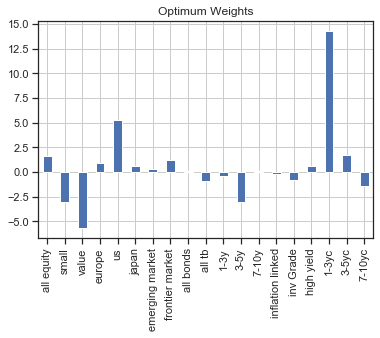

In [162]:
avg_ER_opt.plot(kind='bar', title='Optimum Weights', 
                               grid='True') 